In [ ]:
 from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/ml project')

Mounted at /content/drive


In [ ]:
import numpy as np
seed = 0

In [ ]:
import pandas as pd
df = pd.read_csv('quora_questions.csv')
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
df = df.drop(['id','qid1','qid2'], axis=1)
df.head()

,question1,question2,is_duplicate
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
import re
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet

lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None 


def clean_text(text):
    
    text = re.sub(r'[^\w\s]','',text, re.UNICODE)
    text = text.lower()
    text = text.split(" ")
    text = [i for i in text if i]
    tagged = pos_tag(text)
    tokens = []
    for word, tag in tagged:
        wntag = get_wordnet_pos(tag)
        if wntag is None:
            lemma = lemmatizer.lemmatize(word)
        else:
            lemma = lemmatizer.lemmatize(word, pos=wntag)
        tokens.append(lemma)
    text = " ".join(tokens)
   
    return text

In [ ]:
df['question1'] = df.question1.apply(lambda x: clean_text(str(x)))
df['question2'] = df.question2.apply(lambda x: clean_text(str(x)))
df.head()

,question1,question2,is_duplicate
0,what be the step by step guide to invest in sh...,what be the step by step guide to invest in sh...,0
1,what be the story of kohinoor kohinoor diamond,what would happen if the indian government ste...,0
2,how can i increase the speed of my internet co...,how can internet speed be increase by hack thr...,0
3,why be i mentally very lonely how can i solve it,find the remainder when math2324math be divide...,0
4,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,0


In [ ]:
max_len_q1 = -1
max_len_q2 = -1
total_len_q1 = 0
total_len_q2 = 0

for index, row in df.iterrows():
  q1_len = len(row['question1'].split(" "))
  q2_len = len(row['question2'].split(" "))
  
  if q1_len > max_len_q1:
    max_len_q1 = q1_len
  if q2_len > max_len_q2:
    max_len_q2 = q2_len
  
  total_len_q1 += q1_len
  total_len_q2 += q2_len

In [ ]:
max_len_q1, max_len_q2

(125, 237)

In [ ]:
total_len_q1/df.shape[0], total_len_q2/df.shape[0]

(10.922876411830316, 11.163563339771635)

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , LeakyReLU
from keras.layers import Bidirectional, Concatenate, Dot, GlobalMaxPooling1D
from keras.models import Model

In [ ]:
all_text = pd.concat([df['question1'], df['question2']]).reset_index(drop=True)
all_text.head()

0    what be the step by step guide to invest in sh...
1       what be the story of kohinoor kohinoor diamond
2    how can i increase the speed of my internet co...
3     why be i mentally very lonely how can i solve it
4    which one dissolve in water quikly sugar salt ...
dtype: object

In [ ]:
max_words = 201000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(all_text)
q1_seq = tokenizer.texts_to_sequences(df['question1'])
q2_seq = tokenizer.texts_to_sequences(df['question2'])

In [ ]:
pad_len = 50
q1_pad = pad_sequences(q1_seq, maxlen=pad_len)
q2_pad = pad_sequences(q2_seq, maxlen=pad_len)

In [ ]:
y = df['is_duplicate']

In [ ]:
from sklearn.model_selection import train_test_split

q1_pad_train, q1_pad_val, q2_pad_train, q2_pad_val, y_train, y_val = train_test_split(q1_pad, q2_pad, y, 
                                                                                      random_state=seed,
                                                                                      test_size=0.1)

q1_pad_val, q1_pad_test, q2_pad_val, q2_pad_test, y_val, y_test = train_test_split(q1_pad_val, q2_pad_val, y_val, 
                                                                                   random_state=seed,
                                                                                   test_size=0.5)

q1_pad_train.shape, q1_pad_val.shape, q1_pad_test.shape, y_train.shape, y_val.shape, y_test.shape

((363915, 50), (20218, 50), (20218, 50), (363915,), (20218,), (20218,))

In [ ]:
embedding_size = 512

inp1 = Input(shape=(pad_len,))
inp2 = Input(shape=(pad_len,))

x1 = Embedding(max_words, embedding_size)(inp1)
x2 = Embedding(max_words, embedding_size)(inp2)

x3 = Bidirectional(LSTM(32, return_sequences = True))(x1)
x4 = Bidirectional(LSTM(32, return_sequences = True))(x2)

x5 = GlobalMaxPooling1D()(x3)
x6 = GlobalMaxPooling1D()(x4)

x7 =  Dot(axes=1)([x5, x6])

x8 = Dense(40)(x7)
x9 = LeakyReLU()(x8)
x10 = Dropout(0.05)(x9)

x11 = Dense(10)(x10)
x12 = LeakyReLU()(x11)
x13 = Dropout(0.05)(x12)

output = Dense(1, activation="sigmoid")(x13)

model = Model(inputs=[inp1, inp2], outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 512)      102912000   input_3[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 512)      102912000   input_4[0][0]                    
______________________________________________________________________________________________

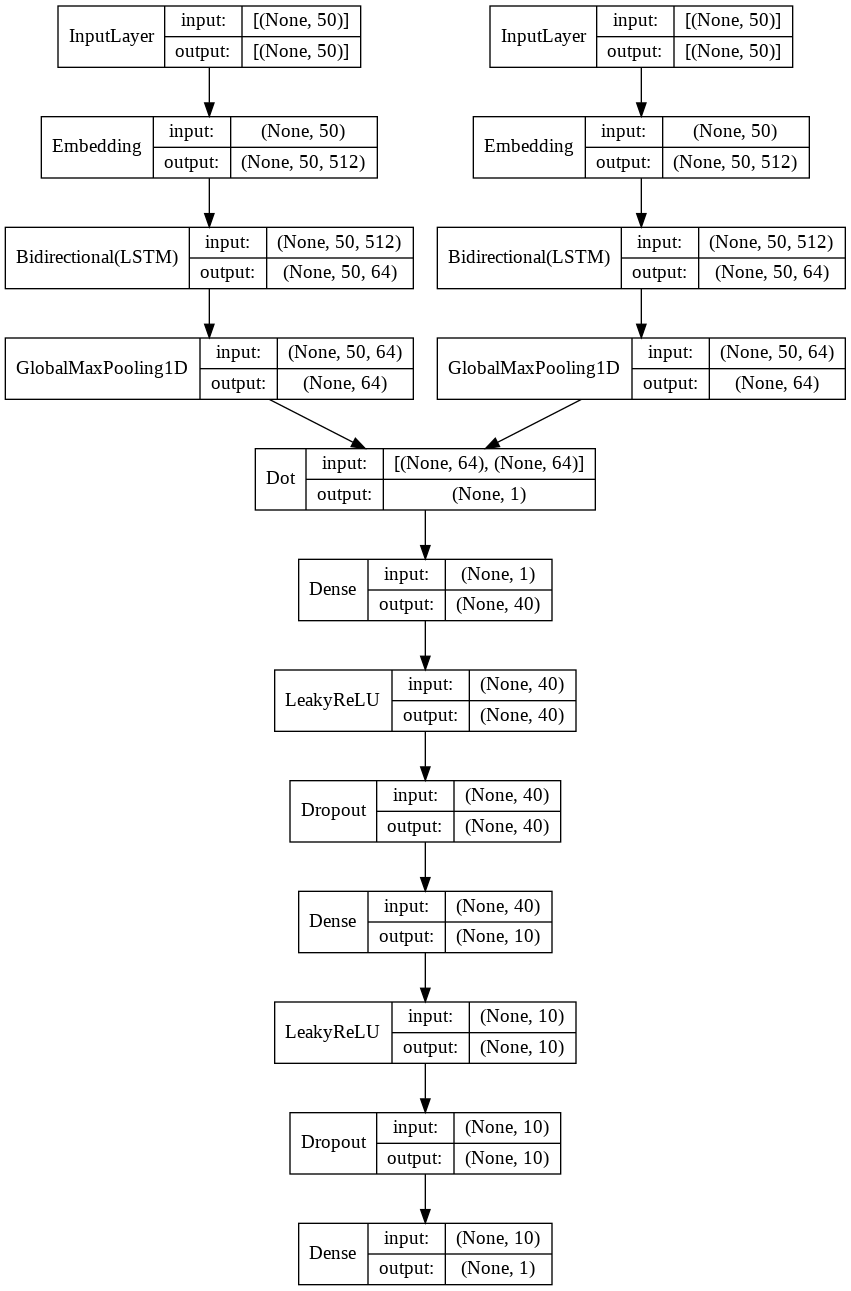

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
batch_size = 100
epochs = 3

In [ ]:
history = model.fit([q1_pad_train, q2_pad_train], y_train,
          batch_size=batch_size, epochs=epochs,
          validation_data=([q1_pad_val, q2_pad_val], y_val))

Epoch 1/3
3640/3640 [==============================] - 758s 205ms/step - loss: 0.5038 - accuracy: 0.7557 - val_loss: 0.4598 - val_accuracy: 0.7821
Epoch 2/3
3640/3640 [==============================] - 746s 205ms/step - loss: 0.3819 - accuracy: 0.8252 - val_loss: 0.4381 - val_accuracy: 0.8007
Epoch 3/3
3640/3640 [==============================] - 747s 205ms/step - loss: 0.2798 - accuracy: 0.8770 - val_loss: 0.4595 - val_accuracy: 0.8043


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred_train = model.predict([q1_pad_train, q2_pad_train])

y_pred_train = np.where(y_pred_train > 0.5, 1, 0)

In [ ]:
print('Train Accuracy: ', str(accuracy_score(y_train, y_pred_train)))
print('Train Precision: ', str(precision_score(y_train, y_pred_train)))
print('Train Recall: ', str(recall_score(y_train, y_pred_train)))
print('Train F1 Score: ', str(f1_score(y_train, y_pred_train)))

Train Accuracy:  0.9266257230397208
Train Precision:  0.9143765491971118
Train Recall:  0.8840520385227967
Train F1 Score:  0.8989586329029622


In [ ]:
y_pred_val = model.predict([q1_pad_val, q2_pad_val])

y_pred_val = np.where(y_pred_val > 0.5, 1, 0)

In [ ]:
print('Validation Accuracy: ', str(accuracy_score(y_val, y_pred_val)))
print('Validation Precision: ', str(precision_score(y_val, y_pred_val)))
print('Validation Recall: ', str(recall_score(y_val, y_pred_val)))
print('Validation F1 Score: ', str(f1_score(y_val, y_pred_val)))

Validation Accuracy:  0.8042833119002869
Validation Precision:  0.7527308838133069
Validation Recall:  0.7055851063829788
Validation F1 Score:  0.7283959091221087


In [ ]:
y_pred_test = model.predict([q1_pad_test, q2_pad_test])

y_pred_test = np.where(y_pred_test > 0.5, 1, 0)

In [ ]:
print('Test Accuracy: ', str(accuracy_score(y_test, y_pred_test)))
print('Test Precision: ', str(precision_score(y_test, y_pred_test)))
print('Test Recall: ', str(recall_score(y_test, y_pred_test)))
print('Test F1 Score: ', str(f1_score(y_test, y_pred_test)))

Test Accuracy:  0.8062617469581561
Test Precision:  0.7506790564689063
Test Recall:  0.7073006465517241
Test F1 Score:  0.7283445453914972


In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 10)

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train Accuracy', 'Val Accuracy', 'Train Loss', 'Val Loss'])

In [ ]:
df.to_csv('clean_data.csv')

In [ ]:
model.save('final_model.h5')